In [128]:
%matplotlib inline

In [129]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import cvxpy as cp
from scipy.linalg import block_diag

Replicate the open-loop case study Van der Pol oscillator in the paper "Linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control"

ref: 
1. https://www.sciencedirect.com/science/article/pii/S000510981830133X
2. https://github.com/MilanKorda/KoopmanMPC/raw/master/KoopmanMPC.zip

In [130]:
def integrator_rk4(f, x, u, delta_t):
    '''
    This function calculates the integration of stage cost with RK4.
    '''

    k1 = f(x, u)
    k2 = f(x + delta_t / 2 * k1, u)
    k3 = f(x + delta_t / 2 * k2, u)
    k4 = f(x + delta_t * k3, u)


    x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [131]:
def rbf_thin_plate(X, Xc):
    '''
    X: n x N_sampe
    Xc: center n x N_rbf
    Plate spline radial basis function with center at x0.
    \psi(x)=\left\|x-x_{0}\right\|^{2} \log \left(\left\|x-x_{0}\right\|\right)
    '''
    
    Nx = np.shape(X)[0]
    N_sample = np.shape(X)[1]
    N_rbf = np.shape(Xc)[1]


    rbf_return_list = []
    for i in range(N_rbf):
        list_temp = []
        for j in range(N_sample):
            inner_p = (X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i])
            list_temp += [inner_p * np.log(np.sqrt(inner_p))]
        rbf_return_list += [list_temp]

    
#     rbf_return_list = [[np.linalg.norm(X[:,j] - Xc[:,i])**2 * np.log(np.linalg.norm(X[:,j] - Xc[:,i])) for j in range(N_sample)]  for i in range(N_rbf)]
#     rbf_return_list = [[(X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]) * np.log(np.sqrt((X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]))) for j in range(N_sample)]  for i in range(N_rbf)]            
    
    
    rbf_refurn_np = np.array(rbf_return_list)
    return rbf_refurn_np


            

$$
\begin{aligned}
&\dot{x}_{1}=2 x_{2} \\
&\dot{x}_{2}=-0.8 x_{1}+2 x_{2}-10 x_{1}^{2} x_{2}+u
\end{aligned}
$$

In [132]:
def lift_func(X, Xc):
    '''
    X: Nx x (N_traj x N_sim)
    Xc: center n x N_rbf
    
    
    N_lift = (N_rbf + Nx)
    
    Return: N_lift x (N_traj x N_sim)
    '''
    
    X_rbf_np = rbf_thin_plate(X, Xc)
    X_lift_np = np.vstack([X_rbf_np, X])
    
    return X_lift_np
    

In [133]:
def van_del_pol_ode(x, u):

    x1p = 2. * x[1]
    x2p = -0.8 * x[0] + 2 * x[1] - 10 * x[0]**2 * x[1] + u[0]

    rhs = [x1p,
           x2p
           ]
    
    return ca.vertcat(*rhs)

In [134]:
np.random.seed(1234)

Nx = 2
Nu = 1

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)

ode = ca.Function("ode_func", [x_SX, u_SX], [van_del_pol_ode(x_SX, u_SX)])
delta_t = 0.01


In [135]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

In [136]:
N_rbf = 50

Xc = np.random.rand(Nx,N_rbf)*2 - 1

N_lift = N_rbf + Nx

# rbf_thin_plate(X,Xc)



In [137]:
N_sim = 200
N_traj = 1000

In [138]:
U_data_np = 2*np.random.rand(N_sim, N_traj) - 1
X_init_data_np = np.random.rand(Nx,N_traj)*2 - 1

In [139]:
X_list = []
Y_list = []
U_list = []

X_current_np = X_init_data_np
for i in range(N_sim):
    X_next_list = [sys_int_fn(X_current_np[:,j],U_data_np[i,j]) for j in range(N_traj)]
    X_next_np = np.hstack(X_next_list)
    
    X_list += [X_current_np] 
    Y_list += [X_next_np]
    U_list += [U_data_np[i,:]]
    
    X_current_np = X_next_np  

In [140]:
X_np = np.hstack(X_list)
Y_np = np.hstack(Y_list)
U_np = np.hstack(U_list).reshape(1,-1)

In [141]:
# How to accelerate this???
X_lift_np = lift_func(X_np, Xc)
Y_lift_np = lift_func(Y_np, Xc)

In [142]:
X_lift_np.shape

(52, 200000)

Regression

In [143]:
X_np.shape

(2, 200000)

In [144]:
W_np = np.vstack([Y_lift_np, X_np])
V_np = np.vstack([X_lift_np, U_np])
VVt_np = V_np @ V_np.T
WVt_np = W_np @ V_np.T
M_np = WVt_np @ np.linalg.pinv(VVt_np)
A_lift_np = M_np[0:N_lift,0:N_lift]
B_lift_np = M_np[0:N_lift,N_lift:]
C_lift_np = M_np[N_lift:,0:N_lift]

print('Regression residual %f \n' %  (np.linalg.norm(Y_lift_np - A_lift_np @ X_lift_np - B_lift_np @ U_np,'fro') / np.linalg.norm(Y_lift_np,'fro')) )

Regression residual 0.008539 



In [355]:
C_lift_np[0,:]

array([-2.32516360e-11,  6.64502710e-09,  5.90437115e-09, -1.01164328e-10,
       -1.31089118e-10,  1.15400429e-11, -1.20239736e-11, -1.58997880e-10,
        1.79656972e-10,  5.07679331e-10,  1.07083193e-10,  7.37766831e-10,
       -2.97588606e-10, -2.26982399e-10,  4.54059032e-10,  8.90486277e-12,
       -1.72578439e-10, -2.72188889e-11,  1.89008187e-10, -3.14650170e-11,
       -2.71979063e-10, -6.42643334e-09,  8.56369144e-11, -5.02000945e-11,
        9.46636085e-11, -6.64613602e-11, -1.03003844e-09,  1.49789470e-10,
        6.31430081e-11,  3.44532146e-11, -1.16447688e-11, -1.58697771e-08,
        5.51161430e-11, -1.49978393e-10, -5.89274294e-10,  6.94306888e-11,
        1.65310170e-10, -4.41075965e-10,  1.28826340e-08, -2.30885283e-11,
        9.27241296e-12,  1.21186558e-10, -1.74154898e-09,  3.50764136e-11,
        1.33636219e-09, -1.00392657e-09,  1.58785272e-09,  2.00672580e-10,
        3.24450807e-11, -2.60765756e-09,  1.00000000e+00, -9.90253108e-13])

In [657]:
N_sim = 300
u_list = [(-1)**(round(i/30)) for i in range(N_sim)]

In [658]:
x0_np = np.array([[0.5],[0.5]])
x_true_np = x0_np

x_lift_np = lift_func(x0_np, Xc)

ValueError: operands could not be broadcast together with shapes (2,) (4,) 

In [147]:
A_lift_np.shape

(52, 52)

In [148]:
x_traj_true_list = []
x_traj_lift_list = []

x_traj_true_list += [x_true_np]
x_traj_lift_list += [x_lift_np]
for i in range(N_sim):
    x_true_np = np.array(sys_int_fn(x_true_np,u_list[i]))
    x_traj_true_list += [x_true_np]
    
    x_lift_np = A_lift_np @ x_lift_np + B_lift_np @ np.array(u_list[i]).reshape(-1,1)
    x_traj_lift_list += [x_lift_np]

In [149]:
x_traj_true_array = np.hstack(x_traj_true_list)
x_traj_lift_array = np.hstack(x_traj_lift_list)

In [150]:
x_koop_array = C_lift_np @ x_traj_lift_array

<ipython-input-151-d4bde42966e7>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
<ipython-input-151-d4bde42966e7>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


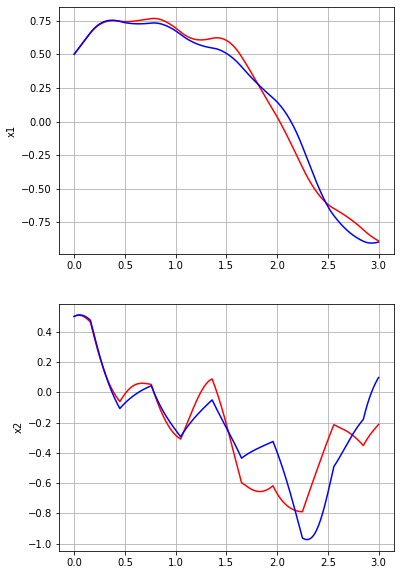

In [151]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_koop = x_koop_array[i,:]
    x_true = x_traj_true_array[i,:]
    plt.plot(tgrid, x_koop, 'r')
    plt.plot(tgrid, x_true, 'b')
    plt.ylabel('x' + str(i + 1))

MPC: simulation

In [294]:
N_sim = 800
x1_start = 0
x2_start = 0.1
x1_ub = 0.04


Koopman operator

In [285]:
obj = 0

N_pred = 25

zi_var = ca.SX.sym('z', N_lift, N_pred+1)
z0_para = ca.SX.sym('z0', N_lift, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


# Q = 10 * np.eye(N_lift)
Q = np.diag([0]* (N_lift-2) + [16] * 2)
R = 1 * np.eye(1)
Qf = np.diag([0]* (N_lift-2) + [16] * 2)
# Qf = 10 * np.eye(N_lift)

g = []


for i in range(N_pred):
    obj +=  zi_var[:,i].T @ Q @  zi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [zi_var[:,i] - z0_para]
    else:
        g += [zi_var[:,i] - (A_lift_np @ zi_var[:,i-1] + B_lift_np @ ui_var[:,i-1])]

obj += zi_var[:, -1].T @ Qf @ zi_var[:, -1]
g += [zi_var[:, -1] - (A_lift_np @ zi_var[:,-2] + B_lift_np @ ui_var[:,-1])] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(zi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [z0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  

In [286]:
lbg =  [0] * N_lift * (N_pred + 1)
ubg =  [0] * N_lift * (N_pred + 1)
lbx = [-ca.inf] * N_lift * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = [ca.inf] * N_lift * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [287]:


x0 = np.array([[x1_start],[x2_start]])
z0 = lift_func(x0, Xc)
u0 = np.array([[0]])

x_pred_list = []
z_pred_list = []
xk = x0
zk = z0
uk = u0


x_pred_list.append(xk.flatten().tolist())
z_pred_list.append(zk.flatten().tolist())

u_ind = ca.reshape(zi_var,-1,1).shape[0]

In [288]:
# Simulation for 20 seconds
for i in range(N_sim):
#     print(xk.shape)
    p = np.vstack([zk])
#     print(p.shape)
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    zk = sol['x'].full()[:u_ind]
    z_pred_list += [zk]
#     print(xk.shape)
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    print(uk,xk)
    x_pred_list.append(x_next.full().flatten().tolist())
    
    xk = x_next.full()
    zk = lift_func(xk, Xc)
#     print(xk.shape)

-0.33278418194723147 [[0. ]
 [0.1]]
-0.3291322473680011 [[0.00198658]
 [0.09865076]]
-0.32543960235490466 [[0.00394611]
 [0.09729513]]
-0.3217081878235172 [[0.00587847]
 [0.09593354]]
-0.3179399362772208 [[0.00778354]
 [0.09456641]]
-0.3141367682845 [[0.00966122]
 [0.09319418]]
-0.310300589280091 [[0.0115114 ]
 [0.09181725]]
-0.30643328667533537 [[0.01333401]
 [0.09043604]]
-0.30253672726095937 [[0.01512895]
 [0.08905095]]
-0.2986127548864408 [[0.01689615]
 [0.0876624 ]]
-0.29466318839838507 [[0.01863555]
 [0.08627079]]
-0.2906898198222562 [[0.0203471]
 [0.0848765]]
-0.28669441277080715 [[0.02203073]
 [0.08347992]]
-0.28267870106409776 [[0.02368641]
 [0.08208144]]
-0.2786443875457914 [[0.02531411]
 [0.08068145]]
-0.2745931430821079 [[0.0269138]
 [0.0792803]]
-0.2705266057296212 [[0.02848545]
 [0.07787838]]
-0.2664463800597294 [[0.03002907]
 [0.07647604]]
-0.2623540366273879 [[0.03154463]
 [0.07507365]]
-0.258251111573552 [[0.03303215]
 [0.07367154]]
-0.25413910635048825 [[0.03449163]
 

0.09938210879446412 [[ 0.0323002 ]
 [-0.03634546]]
0.09961254333467004 [[ 0.03157343]
 [-0.03633019]]
0.09981803855460354 [[ 0.03084706]
 [-0.03630658]]
0.09999882591489791 [[ 0.03012123]
 [-0.03627473]]
0.10015513700141525 [[ 0.02939613]
 [-0.0362347 ]]
0.1002872034967607 [[ 0.0286719 ]
 [-0.03618659]]
0.10039525715712733 [[ 0.02794872]
 [-0.03613049]]
0.10047952979489767 [[ 0.02722674]
 [-0.03606647]]
0.10054025326681693 [[ 0.02650612]
 [-0.03599463]]
0.10057765946802927 [[ 0.02578701]
 [-0.03591505]]
0.10059198033193902 [[ 0.02506957]
 [-0.03582782]]
0.10058344783591648 [[ 0.02435395]
 [-0.03573302]]
0.10055229401287687 [[ 0.0236403 ]
 [-0.03563076]]
0.10049875096848157 [[ 0.02292877]
 [-0.03552112]]
0.10042305090414508 [[ 0.0222195 ]
 [-0.03540418]]
0.1003254261451387 [[ 0.02151264]
 [-0.03528004]]
0.10020610917439694 [[ 0.02080834]
 [-0.03514879]]
0.10006533267068372 [[ 0.02010673]
 [-0.03501053]]
0.09990332955195305 [[ 0.01940796]
 [-0.03486534]]
0.09972033302254815 [[ 0.01871216

-0.014610006026443183 [[-0.01881441]
 [ 0.00754793]]
-0.015193978441985119 [[-0.01866189]
 [ 0.00770398]]
-0.015767153056844528 [[-0.0185063 ]
 [ 0.00785604]]
-0.01632948913207658 [[-0.0183477 ]
 [ 0.00800412]]
-0.016880949552306602 [[-0.01818618]
 [ 0.00814821]]
-0.01742150080442018 [[-0.01802181]
 [ 0.00828833]]
-0.017951112955237467 [[-0.01785469]
 [ 0.00842448]]
-0.018469759627807482 [[-0.01768488]
 [ 0.00855667]]
-0.01897741797667159 [[-0.01751246]
 [ 0.00868491]]
-0.01947406866195602 [[-0.01733752]
 [ 0.00880921]]
-0.019959695822314813 [[-0.01716014]
 [ 0.00892959]]
-0.020434287046738588 [[-0.01698038]
 [ 0.00904605]]
-0.020897833345362462 [[-0.01679834]
 [ 0.00915861]]
-0.021350329119014185 [[-0.01661408]
 [ 0.00926728]]
-0.021791772127939917 [[-0.01642769]
 [ 0.00937208]]
-0.022222163459309222 [[-0.01623924]
 [ 0.00947303]]
-0.02264150749375038 [[-0.01604881]
 [ 0.00957015]]
-0.023049811870852054 [[-0.01585647]
 [ 0.00966345]]
-0.02344708745387332 [[-0.01566231]
 [ 0.00975295]]

-0.006332544234605608 [[0.0052394 ]
 [0.00074896]]
-0.006049593087021161 [[0.00525347]
 [0.00065773]]
-0.005768604697755008 [[0.00526572]
 [0.00056741]]
-0.005489630629255453 [[0.00527618]
 [0.00047801]]
-0.005212721241613739 [[0.00528486]
 [0.00038954]]
-0.0049379256955846065 [[0.00529177]
 [0.00030203]]
-0.004665291955910686 [[0.00529695]
 [0.00021547]]
-0.004394866794906237 [[0.00530041]
 [0.00012988]]
-0.004126695796301886 [[5.30216331e-03]
 [4.52762192e-05]]
-0.0038608233593963983 [[ 5.30223549e-03]
 [-3.83372819e-05]]
-0.0035972927034004743 [[ 0.00530065]
 [-0.00012095]]
-0.003336145872071065 [[ 0.00529741]
 [-0.00020255]]
-0.0030774237386138924 [[ 0.00529256]
 [-0.00028312]]
-0.002821166010758813 [[ 0.0052861 ]
 [-0.00036267]]
-0.0025674112360806896 [[ 0.00527807]
 [-0.00044117]]
-0.002316196807586557 [[ 0.00526847]
 [-0.00051863]]
-0.0020675589695025955 [[ 0.00525734]
 [-0.00059502]]
-0.0018215328232316953 [[ 0.00524469]
 [-0.00067036]]
-0.0015781523335876167 [[ 0.00523054]
 [-

0.005251872735685611 [[-0.00180384]
 [-0.00173299]]
0.005166378341943944 [[-0.00183817]
 [-0.00170024]]
0.005080306161772215 [[-0.00187185]
 [-0.00166741]]
0.004993685862999161 [[-0.00190487]
 [-0.00163452]]
0.004906546921317605 [[-0.00193723]
 [-0.00160158]]
0.0048189186146934924 [[-0.00196893]
 [-0.00156859]]
0.004730830017905502 [[-0.00199998]
 [-0.00153557]]
0.004642309997134423 [[-0.00203036]
 [-0.00150252]]
0.004553387204731627 [[-0.00206008]
 [-0.00146945]]
0.0044640900739803665 [[-0.00208914]
 [-0.00143638]]
0.004374446814129599 [[-0.00211754]
 [-0.00140331]]
0.004284485405391781 [[-0.00214528]
 [-0.00137025]]
0.004194233594072461 [[-0.00217235]
 [-0.00133721]]
0.0041037188879518415 [[-0.00219877]
 [-0.0013042 ]]
0.004012968551546843 [[-0.00222452]
 [-0.00127122]]
0.003922009601664533 [[-0.00224962]
 [-0.00123829]]
0.003830868802945677 [[-0.00227406]
 [-0.00120541]]
0.003739572663685975 [[-0.00229784]
 [-0.0011726 ]]
0.003648147431503544 [[-0.00232097]
 [-0.00113985]]
0.0035566

-0.0033501124699630027 [[-0.00137872]
 [ 0.00090662]]
-0.0033456596196463585 [[-0.00136063]
 [ 0.00090216]]


Nonlinear MPC

In [289]:
obj = 0

N_pred = 25

xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)
lbx = [-ca.inf] * 2 * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = [ca.inf] * 2 * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [290]:
x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[0]])

x_real_list = []
x_real_pred_list = []
xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [291]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    
    x_real_pred_list += [sol['x'].full()[:u_ind]]
    
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())

    x_lin = xk
    xk = x_next

<ipython-input-292-c7edd552f516>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
<ipython-input-292-c7edd552f516>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


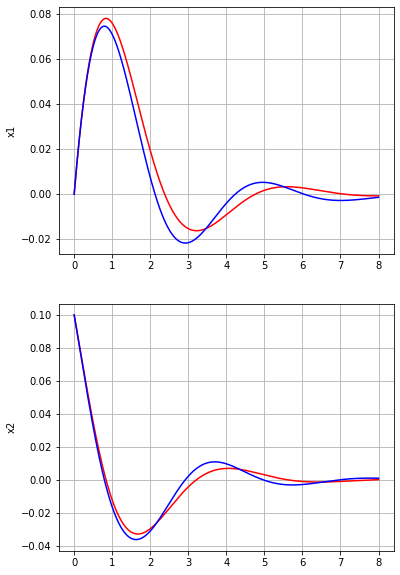

In [292]:
x_plot_real = np.array(x_real_list)
x_plot_pred = np.array(x_pred_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    
#     if i == 1:
#         constr_plot_temp = [0.65] * (N_sim + 1)
#         plt.plot(tgrid, constr_plot_temp, color="k")
    
    x_opt_real = x_plot_real[:,i]
    x_opt_pred = x_plot_pred[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_pred, 'b')
    plt.ylabel('x' + str(i + 1))

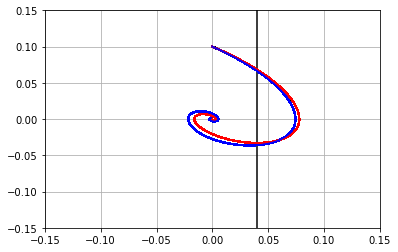

In [295]:
fig1, ax1 = plt.subplots(num=4)

plt.grid()
plt.axis([-0.15, 0.15, -0.15, 0.15])

# P_VT.plot(ax10, fill=False, edgecolor='r', linewidth=2)
for i in range(len(tgrid)):
#     x_traj_array = np.hstack(x_diff_traj_list[i])
    ax1.plot(x_plot_real[:,0],x_plot_real[:,1],'r')
    ax1.plot(x_plot_pred[:,0],x_plot_pred[:,1],'b')
ax1.vlines(x1_ub,-0.15,0.15,colors='k')

#### Van del pol with constraints

In [306]:
obj = 0

N_pred = 25

zi_var = ca.SX.sym('z', N_lift, N_pred+1)
z0_para = ca.SX.sym('z0', N_lift, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


# Q = 10 * np.eye(N_lift)
Q = np.diag([0]* (N_lift-2) + [16] * 2)
R = 1 * np.eye(1)
Qf = np.diag([0]* (N_lift-2) + [16] * 2)
# Qf = 10 * np.eye(N_lift)

g = []


for i in range(N_pred):
    obj +=  zi_var[:,i].T @ Q @  zi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [zi_var[:,i] - z0_para]
    else:
        g += [zi_var[:,i] - (A_lift_np @ zi_var[:,i-1] + B_lift_np @ ui_var[:,i-1])]

obj += zi_var[:, -1].T @ Qf @ zi_var[:, -1]
g += [zi_var[:, -1] - (A_lift_np @ zi_var[:,-2] + B_lift_np @ ui_var[:,-1])] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(zi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [z0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  

In [307]:
lbg =  [0] * N_lift * (N_pred + 1)
ubg =  [0] * N_lift * (N_pred + 1)
lbx = [-ca.inf] * N_lift * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = ([ca.inf] * (N_lift-2) + [x1_ub, ca.inf])  * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [308]:
x0 = np.array([[x1_start],[x2_start]])
z0 = lift_func(x0, Xc)
u0 = np.array([[0]])

x_pred_list = []
z_pred_list = []
xk = x0
zk = z0
uk = u0


x_pred_list.append(xk.flatten().tolist())
z_pred_list.append(zk.flatten().tolist())

u_ind = ca.reshape(zi_var,-1,1).shape[0]

In [309]:
# Simulation for 20 seconds
for i in range(N_sim):
#     print(xk.shape)
    p = np.vstack([zk])
#     print(p.shape)
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    zk = sol['x'].full()[:u_ind]
    z_pred_list += [zk]
#     print(xk.shape)
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    print(uk,xk)
    x_pred_list.append(x_next.full().flatten().tolist())
    
    xk = x_next.full()
    zk = lift_func(xk, Xc)
#     print(xk.shape)

-0.6371150451035534 [[0. ]
 [0.1]]
-0.6086540701753893 [[0.00195594]
 [0.0955769 ]]
-0.5816355536034308 [[0.00382524]
 [0.09133639]]
-0.5559051607494445 [[0.00561145]
 [0.08726824]]
-0.5313350377475662 [[0.00731792]
 [0.08336353]]
-0.5078192380522587 [[0.00894785]
 [0.07961446]]
-0.48526986250298737 [[0.01050427]
 [0.0760141 ]]
-0.4636138300140212 [[0.01199011]
 [0.07255627]]
-0.4427901911243526 [[0.01340816]
 [0.0692354 ]]
-0.4227479013425432 [[0.0147611 ]
 [0.06604638]]
-0.4034439800248995 [[0.01605153]
 [0.0629845 ]]
-0.384841990544566 [[0.01728194]
 [0.06004539]]
-0.36691078728013987 [[0.01845476]
 [0.05722493]]
-0.34962348381162534 [[0.0195723]
 [0.0545192]]
-0.3329566044188484 [[0.02063684]
 [0.05192448]]
-0.3168893875249643 [[0.02165055]
 [0.04943718]]
-0.30140321519527047 [[0.02261556]
 [0.04705383]]
-0.28648114732068974 [[0.02353389]
 [0.04477106]]
-0.2721075428362422 [[0.02440754]
 [0.04258559]]
-0.2582677533638448 [[0.02523842]
 [0.04049423]]
-0.24494787715880376 [[0.0260283

0.053551829000030284 [[ 0.00855754]
 [-0.01865891]]
0.05342744989286666 [[ 0.00818531]
 [-0.01856245]]
0.053290981113034416 [[ 0.00781506]
 [-0.01846232]]
0.053142582295003585 [[ 0.00744684]
 [-0.01835856]]
0.05298241399269289 [[ 0.00708073]
 [-0.01825126]]
0.0528106376566712 [[ 0.00671681]
 [-0.01814046]]
0.05262741561123441 [[ 0.00635513]
 [-0.01802624]]
0.052432911031051535 [[ 0.00599577]
 [-0.01790866]]
0.05222728791748232 [[ 0.0056388 ]
 [-0.01778778]]
0.05201071107459303 [[ 0.00528428]
 [-0.01766366]]
0.051783346084758236 [[ 0.00493227]
 [-0.01753639]]
0.05154535928383652 [[ 0.00458284]
 [-0.017406  ]]
0.051296917735943956 [[ 0.00423604]
 [-0.01727259]]
0.051038189207731254 [[ 0.00389194]
 [-0.01713619]]
0.050769342142271426 [[ 0.0035506]
 [-0.0169969]]
0.0504905456324695 [[ 0.00321208]
 [-0.01685476]]
0.050201969393955694 [[ 0.00287642]
 [-0.01670985]]
0.04990378373741515 [[ 0.00254369]
 [-0.01656222]]
0.049596159540729864 [[ 0.00221394]
 [-0.01641195]]
0.049279268220203024 [[ 0

-0.0135278469842982 [[-0.00875402]
 [ 0.00538624]]
-0.013723152059132361 [[-0.00864587]
 [ 0.00542867]]
-0.013912577911105173 [[-0.00853689]
 [ 0.00546911]]
-0.014096140664817462 [[-0.00842713]
 [ 0.00550756]]
-0.014273857944195174 [[-0.00831661]
 [ 0.00554406]]
-0.014445748850038747 [[-0.00820538]
 [ 0.00557859]]
-0.014611833937467605 [[-0.00809348]
 [ 0.00561119]]
-0.014772135193151006 [[-0.00798095]
 [ 0.00564187]]
-0.014926676012177804 [[-0.00786783]
 [ 0.00567063]]
-0.015075481174654574 [[-0.00775415]
 [ 0.0056975 ]]
-0.015218576822340122 [[-0.00763995]
 [ 0.00572249]]
-0.015355990434790473 [[-0.00752526]
 [ 0.00574561]]
-0.015487750805515482 [[-0.00741014]
 [ 0.00576689]]
-0.015613888017878542 [[-0.0072946 ]
 [ 0.00578633]]
-0.01573443342073563 [[-0.0071787 ]
 [ 0.00580396]]
-0.015849419604191874 [[-0.00706246]
 [ 0.00581979]]
-0.015958880374890367 [[-0.00694592]
 [ 0.00583384]]
-0.01606285073140609 [[-0.00682912]
 [ 0.00584612]]
-0.01616136683939099 [[-0.00671209]
 [ 0.00585666]

-0.0015134497696731278 [[ 0.00244709]
 [-0.00031002]]
-0.0013787912607989294 [[ 0.00244048]
 [-0.00035132]]
-0.0012455570543693127 [[ 0.00243305]
 [-0.00039204]]
-0.0011137657936209715 [[ 0.0024248 ]
 [-0.00043216]]
-0.0009834355083721863 [[ 0.00241577]
 [-0.0004717 ]]
-0.0008545836181401631 [[ 0.00240594]
 [-0.00051065]]
-0.0007272269351362952 [[ 0.00239535]
 [-0.00054899]]
-0.0006013816675851827 [[ 0.00238399]
 [-0.00058674]]
-0.0004770634230062034 [[ 0.00237189]
 [-0.00062388]]
-0.00035428721177126557 [[ 0.00235905]
 [-0.00066042]]
-0.0002330674506182375 [[ 0.00234548]
 [-0.00069634]]
-0.00011341796625496298 [[ 0.0023312 ]
 [-0.00073166]]
4.64800069649017e-06 [[ 0.00231622]
 [-0.00076636]]
0.00012111779197682729 [[ 0.00230055]
 [-0.00080045]]
0.00023597932761779881 [[ 0.00228421]
 [-0.00083392]]
0.000349221101907048 [[ 0.0022672 ]
 [-0.00086678]]
0.0004608321792494421 [[ 0.00224955]
 [-0.00089901]]
0.0005708021898524925 [[ 0.00223125]
 [-0.00093062]]
0.0006791213254388232 [[ 0.00221

0.0018117226557398001 [[-0.0016365 ]
 [-0.00067643]]
0.001762043559915117 [[-0.00164985]
 [-0.00065852]]
0.0017122796941850154 [[-0.00166285]
 [-0.00064064]]
0.001662445412055965 [[-0.00167548]
 [-0.0006228 ]]
0.0016125549196372697 [[-0.00168776]
 [-0.000605  ]]
0.0015626222735834723 [[-0.00169968]
 [-0.00058725]]
0.0015126613789892254 [[-0.00171125]
 [-0.00056955]]
0.001462685987465587 [[-0.00172247]
 [-0.0005519 ]]
0.0014127096951215203 [[-0.00173333]
 [-0.00053431]]
0.0013627459408125382 [[-0.00174384]
 [-0.00051679]]
0.0013128080042755974 [[-0.001754  ]
 [-0.00049933]]
0.0012629090043698888 [[-0.00176382]
 [-0.00048195]]
0.00121306189748032 [[-0.00177328]
 [-0.00046463]]
0.0011632794758324166 [[-0.0017824]
 [-0.0004474]]
0.00111357436593121 [[-0.00179118]
 [-0.00043025]]
0.0010639590271425679 [[-0.00179962]
 [-0.00041319]]
0.0010144457501967484 [[-0.00180771]
 [-0.00039621]]
0.0009650466558580389 [[-0.00181547]
 [-0.00037933]]
0.0009157736935728108 [[-0.00182289]
 [-0.00036255]]
0.

-0.0020974188617932173 [[-0.00104156]
 [ 0.00045518]]
-0.0020908046784619493 [[-0.00103249]
 [ 0.00045157]]
-0.0020839000867918776 [[-0.0010235 ]
 [ 0.00044788]]
-0.0020767103884604733 [[-0.00101458]
 [ 0.00044411]]
-0.002069240899406773 [[-0.00100573]
 [ 0.00044027]]
-0.002061496948298441 [[-0.00099697]
 [ 0.00043636]]
-0.0020534838749221166 [[-0.00098828]
 [ 0.00043237]]
-0.0020452070285387793 [[-0.00097967]
 [ 0.00042831]]
-0.002036671766402237 [[-0.00097115]
 [ 0.00042419]]
-0.002027883452132879 [[-0.0009627]
 [ 0.00042  ]]


In [310]:
obj = 0

N_pred = 25

xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)
lbx = [-ca.inf] * 2 * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = [x1_ub, ca.inf] * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [311]:
x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[0]])

x_real_list = []
x_real_pred_list = []
xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [312]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    
    x_real_pred_list += [sol['x'].full()[:u_ind]]
    
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())

    x_lin = xk
    xk = x_next

<ipython-input-313-c7edd552f516>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
<ipython-input-313-c7edd552f516>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


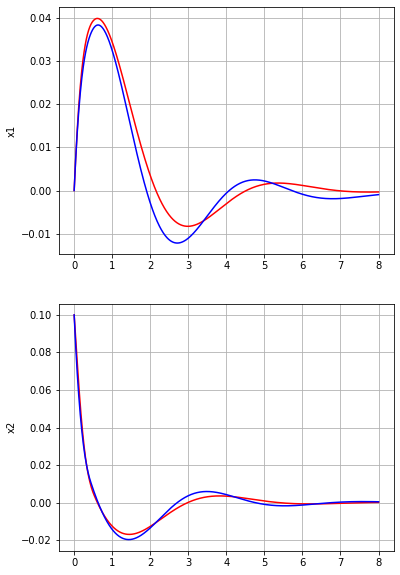

In [313]:
x_plot_real = np.array(x_real_list)
x_plot_pred = np.array(x_pred_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    
#     if i == 1:
#         constr_plot_temp = [0.65] * (N_sim + 1)
#         plt.plot(tgrid, constr_plot_temp, color="k")
    
    x_opt_real = x_plot_real[:,i]
    x_opt_pred = x_plot_pred[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_pred, 'b')
    plt.ylabel('x' + str(i + 1))

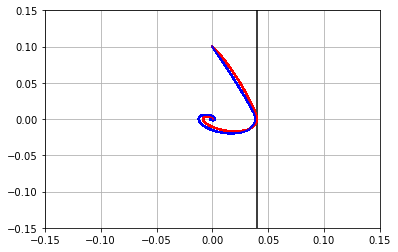

In [314]:
fig1, ax1 = plt.subplots(num=4)

plt.grid()
plt.axis([-0.15, 0.15, -0.15, 0.15])

# P_VT.plot(ax10, fill=False, edgecolor='r', linewidth=2)
for i in range(len(tgrid)):
#     x_traj_array = np.hstack(x_diff_traj_list[i])
    ax1.plot(x_plot_real[:,0],x_plot_real[:,1],'r')
    ax1.plot(x_plot_pred[:,0],x_plot_pred[:,1],'b')
ax1.vlines(x1_ub,-0.15,0.15,colors='k')

#### Van del pol under disturbance

In [344]:
dis_scale = 1e-3

In [324]:
obj = 0

N_pred = 25

zi_var = ca.SX.sym('z', N_lift, N_pred+1)
z0_para = ca.SX.sym('z0', N_lift, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


# Q = 10 * np.eye(N_lift)
Q = np.diag([0]* (N_lift-2) + [16] * 2)
R = 1 * np.eye(1)
Qf = np.diag([0]* (N_lift-2) + [16] * 2)
# Qf = 10 * np.eye(N_lift)

g = []


for i in range(N_pred):
    obj +=  zi_var[:,i].T @ Q @  zi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [zi_var[:,i] - z0_para]
    else:
        g += [zi_var[:,i] - (A_lift_np @ zi_var[:,i-1] + B_lift_np @ ui_var[:,i-1])]

obj += zi_var[:, -1].T @ Qf @ zi_var[:, -1]
g += [zi_var[:, -1] - (A_lift_np @ zi_var[:,-2] + B_lift_np @ ui_var[:,-1])] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(zi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [z0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  

In [325]:
lbg =  [0] * N_lift * (N_pred + 1)
ubg =  [0] * N_lift * (N_pred + 1)
lbx = [-ca.inf] * N_lift * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = ([ca.inf] * (N_lift-2) + [x1_ub, ca.inf])  * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [326]:
x0 = np.array([[x1_start],[x2_start]])
z0 = lift_func(x0, Xc)
u0 = np.array([[0]])

x_pred_list = []
z_pred_list = []
xk = x0
zk = z0
uk = u0


x_pred_list.append(xk.flatten().tolist())
z_pred_list.append(zk.flatten().tolist())

u_ind = ca.reshape(zi_var,-1,1).shape[0]

In [327]:
# Simulation for 20 seconds
for i in range(N_sim):
#     print(xk.shape)
    p = np.vstack([zk])
#     print(p.shape)
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    zk = sol['x'].full()[:u_ind]
    z_pred_list += [zk]
#     print(xk.shape)
    x_next = integrator_rk4(ode,xk,uk,delta_t) + dis_scale * ca.DM.rand(2,1)
    print(uk,xk)
    x_pred_list.append(x_next.full().flatten().tolist())
    
    xk = x_next.full()
    zk = lift_func(xk, Xc)
#     print(xk.shape)

-0.6371150451035534 [[0. ]
 [0.1]]
-0.6318537314993296 [[0.00235823]
 [0.09621658]]
-0.635727026630591 [[0.00516081]
 [0.09224324]]
-0.6278402349048424 [[0.0074826 ]
 [0.08834091]]
-0.6028268715227411 [[0.00951079]
 [0.08393502]]
-0.586443939998065 [[0.01126855]
 [0.08038728]]
-0.5717700859169877 [[0.0135418 ]
 [0.07613601]]
-0.5418494623948836 [[0.01528846]
 [0.07182908]]
-0.5322989694765093 [[0.01751447]
 [0.06789647]]
-0.5253653277195024 [[0.01962062]
 [0.0642799 ]]
-0.5136817234048155 [[0.02133664]
 [0.06098802]]
-0.49528907681748724 [[0.02285834]
 [0.05761067]]
-0.48998042977056694 [[0.02471462]
 [0.05444165]]
-0.46463683733523164 [[0.02608922]
 [0.05088151]]
-0.44597796474402734 [[0.0276778 ]
 [0.04735655]]
-0.4276863946282481 [[0.02900484]
 [0.0442511 ]]
-0.40177786943118443 [[0.02990092]
 [0.04137772]]
-0.38735850727714133 [[0.03146181]
 [0.03811438]]
-0.36375142994010545 [[0.03244731]
 [0.0352203 ]]
-0.34107913599094924 [[0.03332586]
 [0.03254244]]
-0.3164380882152572 [[0.0342

-1.2700206422878262 [[0.12625115]
 [0.01414462]]
1.4069206247533077 [[0.12652133]
 [0.00079228]]
-1.379687205746038 [[0.12677465]
 [0.01473069]]
1.4172964366502405 [[0.12742229]
 [0.00088259]]
-1.410098019611868 [[0.12842206]
 [0.01502994]]
1.466045618960821 [[0.12934208]
 [0.00066384]]
-1.4367119611437236 [[0.12951735]
 [0.01526042]]
1.5108155621726218 [[0.13064146]
 [0.00083595]]
-1.3822871716682037 [[0.13156353]
 [0.01517953]]
1.5274877791012047 [[0.13269598]
 [0.00092391]]
-1.4671337927978543 [[0.13299479]
 [0.01572641]]
1.551017092663146 [[0.13354528]
 [0.00084074]]
-1.4411232090177823 [[0.13373523]
 [0.01566611]]
1.569640766364816 [[0.13445602]
 [0.00080257]]
-1.503741499922115 [[0.13558078]
 [0.01614155]]
1.5903630672655036 [[0.13594015]
 [0.00088174]]
-1.4773188604717569 [[0.13683738]
 [0.01612617]]
1.6520055773561408 [[0.13799574]
 [0.00050888]]
-1.4724613931953987 [[0.13881974]
 [0.01628268]]
1.6222416523368293 [[0.13917625]
 [0.00111837]]
-1.565145698859686 [[0.13992595]
 [0

-3.3132158091536548 [[0.2520616 ]
 [0.03540954]]
3.5298559746639198 [[0.25243306]
 [0.00061924]]
-3.1932221168638977 [[0.25290005]
 [0.03489049]]
3.4551991458487623 [[0.25330413]
 [0.00213273]]
-3.2775538011328424 [[0.25437765]
 [0.0354344 ]]
3.572725899306026 [[0.2556498 ]
 [0.00152316]]
-3.25285534626561 [[0.25701444]
 [0.03554092]]
3.588982672865058 [[0.25812717]
 [0.00177118]]
-3.383081782733336 [[0.25874285]
 [0.03633287]]
3.625652984030418 [[0.25994021]
 [0.00166186]]
-3.4469470559719833 [[0.2606524 ]
 [0.03681314]]
3.668668526966898 [[0.26171782]
 [0.00074489]]
-3.2406897753472226 [[0.26299456]
 [0.03599795]]
3.6112276551730007 [[0.26359744]
 [0.00224869]]
-3.47424368568639 [[0.26430786]
 [0.03726383]]
3.7259753241691396 [[0.26536205]
 [0.00075594]]
-3.241164313318367 [[0.26659948]
 [0.03631152]]
3.5569224052230486 [[0.26699893]
 [0.00280473]]
-3.422015076157801 [[0.26763859]
 [0.03729372]]
3.76448230407213 [[0.26845192]
 [0.00175496]]
-3.628152328267473 [[0.26939352]
 [0.038462

6.082241131645422 [[0.42358864]
 [0.00268596]]
-5.334063799305861 [[0.42456283]
 [0.06048411]]
5.923137706246332 [[0.42568304]
 [0.00470934]]
-5.41945185015709 [[0.42710213]
 [0.06113718]]
6.006310547915433 [[0.42803311]
 [0.00448866]]
-5.45344585246593 [[0.42957841]
 [0.06152953]]
6.1582537841165985 [[0.43070366]
 [0.00399012]]
-5.7098249124071065 [[0.43187076]
 [0.06301034]]
6.234227122754133 [[0.43325934]
 [0.00299358]]
-5.6213160846277 [[0.43447151]
 [0.06280582]]
6.269471170698386 [[0.4358338]
 [0.0036495]]
-5.774076705326466 [[0.4371759 ]
 [0.06380973]]
6.331075395987959 [[0.43851855]
 [0.00291709]]
-5.622908895834908 [[0.4398997 ]
 [0.06330535]]
6.296092855566725 [[0.4409308 ]
 [0.00414936]]
-5.672060993313038 [[0.44207602]
 [0.06374698]]
6.297597064256849 [[0.44365516]
 [0.00445703]]
-5.752024503273386 [[0.44465376]
 [0.06437837]]
6.438624556429394 [[0.44631693]
 [0.00394109]]
-5.878790470086873 [[0.44771782]
 [0.06528693]]
6.503808708307015 [[0.44915085]
 [0.00297641]]
-5.7583

-8.26637814582859 [[0.65607634]
 [0.09697774]]
9.529787259346012 [[0.65749291]
 [0.00800841]]
-8.288297156133746 [[0.65930341]
 [0.0974061 ]]
9.48202129050666 [[0.6609201 ]
 [0.00856965]]
-8.18030188074949 [[0.66295462]
 [0.0972237 ]]
9.45351804315013 [[0.66406971]
 [0.00900112]]
-8.099601627402615 [[0.66593102]
 [0.09711166]]
9.330846681092417 [[0.66728254]
 [0.00991889]]
-8.096065345294916 [[0.66904677]
 [0.09740084]]
9.387018349853472 [[0.67055553]
 [0.00994234]]
-8.04209534749535 [[0.67216827]
 [0.09743709]]
9.249271798520285 [[0.67416076]
 [0.01096623]]
-7.988364306803891 [[0.67529047]
 [0.09747444]]
9.150422371755925 [[0.67658263]
 [0.0116856 ]]
-7.76692930049049 [[0.67776875]
 [0.09660544]]
9.019964403198747 [[0.6796885 ]
 [0.01262659]]
-7.709733736752543 [[0.68120808]
 [0.09665613]]
8.988237094516697 [[0.68282347]
 [0.01307624]]
-7.612575615851073 [[0.68448507]
 [0.09648977]]
8.804230446445832 [[0.68655702]
 [0.01434328]]
-7.39150203155324 [[0.68772113]
 [0.09569619]]
8.6761711

In [345]:
obj = 0

N_pred = 25

xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)
lbx = [-ca.inf] * 2 * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = [x1_ub, ca.inf] * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [346]:
x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[0]])

x_real_list = []
x_real_pred_list = []
xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [347]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    
    x_real_pred_list += [sol['x'].full()[:u_ind]]
    
    x_next = integrator_rk4(ode,xk,uk,delta_t) + dis_scale * ca.DM.rand(2,1)
    
    x_real_list.append(x_next.full().flatten().tolist())

    x_lin = xk
    xk = x_next

<ipython-input-348-c7edd552f516>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
<ipython-input-348-c7edd552f516>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


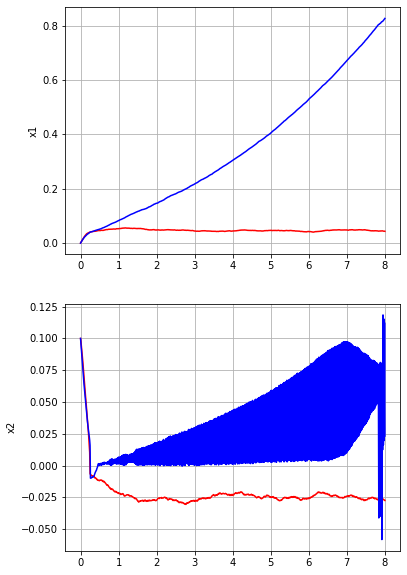

In [348]:
x_plot_real = np.array(x_real_list)
x_plot_pred = np.array(x_pred_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    
#     if i == 1:
#         constr_plot_temp = [0.65] * (N_sim + 1)
#         plt.plot(tgrid, constr_plot_temp, color="k")
    
    x_opt_real = x_plot_real[:,i]
    x_opt_pred = x_plot_pred[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_pred, 'b')
    plt.ylabel('x' + str(i + 1))

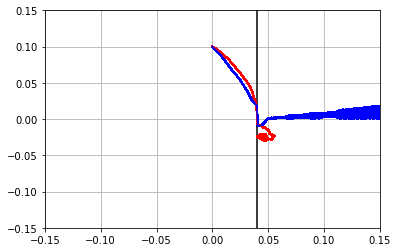

In [349]:
fig1, ax1 = plt.subplots(num=4)

plt.grid()
plt.axis([-0.15, 0.15, -0.15, 0.15])

# P_VT.plot(ax10, fill=False, edgecolor='r', linewidth=2)
for i in range(len(tgrid)):
#     x_traj_array = np.hstack(x_diff_traj_list[i])
    ax1.plot(x_plot_real[:,0],x_plot_real[:,1],'r')
    ax1.plot(x_plot_pred[:,0],x_plot_pred[:,1],'b')
ax1.vlines(x1_ub,-0.15,0.15,colors='k')

Case 2: inverted pendulum

In [577]:
def inverted_pendulum_nonlinear_ode(x, u):
    M  = 2.4
    m = 0.23
    l = 0.36
    g = 9.81

    dx1_dt = x[1]
    dx2_dt = ( u * ca.cos(x[0]) - (M+m) * g * ca.sin(x[0]) + m * l * ca.cos(x[0]) *ca.sin(x[0])*x[1]**2) / (m*l*ca.cos(x[0])**2 - (M+m) *l)
    dx3_dt = x[3]
    dx4_dt = (u + m*l * ca.sin(x[0]) * x[1]**2 - m*g*ca.cos(x[0])*ca.sin(x[0]))/(M+m-m*ca.cos(x[0])**2)
    rhs = [dx1_dt,
           dx2_dt,
           dx3_dt,
           dx4_dt
           ]
    
    return ca.vertcat(*rhs)

In [578]:
Nx = 4
Nu = 1

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1


In [579]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

In [593]:
N_rbf = 100

Xc = np.random.normal(0,1,[Nx,N_rbf])

N_lift = N_rbf + Nx

# rbf_thin_plate(X,Xc)



In [594]:
N_sim = 200
N_traj = 2000

In [595]:
X_init_data_np = np.random.normal(0,1,[N_sim, N_traj])
X_init_data_np.shape

(200, 2000)

In [596]:
U_data_np = np.random.normal(0,20,[N_sim, N_traj])
# U_data_np = 20*np.random.rand(N_sim, N_traj) - 10
# X_init_data_np = np.random.rand(Nx,N_traj)*0.1
X_init_data_np = np.random.normal(0,1,[Nx, N_traj])

In [597]:
X_list = []
Y_list = []
U_list = []

X_current_np = X_init_data_np
for i in range(N_sim):
    X_next_list = [sys_int_fn(X_current_np[:,j],U_data_np[i,j]) for j in range(N_traj)]
    X_next_np = np.hstack(X_next_list)
    
    X_list += [X_current_np] 
    Y_list += [X_next_np]
    U_list += [U_data_np[i,:]]
    
    X_current_np = X_next_np  

In [598]:
X_np = np.hstack(X_list)
Y_np = np.hstack(Y_list)
U_np = np.hstack(U_list).reshape(1,-1)

In [599]:
# How to accelerate this???
X_lift_np = lift_func(X_np, Xc)
Y_lift_np = lift_func(Y_np, Xc)

In [600]:
X_lift_np.shape

(104, 400000)

In [601]:
W_np = np.vstack([Y_lift_np, X_np])
V_np = np.vstack([X_lift_np, U_np])
VVt_np = V_np @ V_np.T
WVt_np = W_np @ V_np.T
M_np = WVt_np @ np.linalg.pinv(VVt_np)
A_lift_np = M_np[0:N_lift,0:N_lift]
B_lift_np = M_np[0:N_lift,N_lift:]
C_lift_np = M_np[N_lift:,0:N_lift]

print('Regression residual %f \n' %  (np.linalg.norm(Y_lift_np - A_lift_np @ X_lift_np - B_lift_np @ U_np,'fro') / np.linalg.norm(Y_lift_np,'fro')) )

Regression residual 0.007527 



In [647]:
N_sim =10
# u_list = [(-1)**(round(i/30)) for i in range(N_sim)]
u_list = np.random.normal(0,20,N_sim)

In [648]:
u_list

array([ 15.48045408, -26.30386472, -24.75598804,   1.25647866,
        -4.8897411 ,  -1.04294313,  17.8674621 ,  -4.29790317,
        -1.58651219, -20.67021627])

In [649]:
x0_np = np.array([[0]*4]).reshape(-1,1)
x_true_np = x0_np

x_lift_np = lift_func(x0_np, Xc)

In [650]:
x0_np.shape

(4, 1)

In [651]:
x_lift_np.shape

(104, 1)

In [652]:
x_traj_true_list = []
x_traj_lift_list = []

x_traj_true_list += [x_true_np]
x_traj_lift_list += [x_lift_np]
for i in range(N_sim):
    x_true_np = np.array(sys_int_fn(x_true_np,u_list[i]))
    x_traj_true_list += [x_true_np]
    
    x_lift_np = A_lift_np @ x_lift_np + B_lift_np @ np.array(u_list[i]).reshape(-1,1)
    x_traj_lift_list += [x_lift_np]

In [653]:
x_traj_true_array = np.hstack(x_traj_true_list)
x_traj_lift_array = np.hstack(x_traj_lift_list)

In [654]:
x_koop_array = C_lift_np @ x_traj_lift_array

<ipython-input-655-d7458fa182b4>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
<ipython-input-655-d7458fa182b4>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
<ipython-input-655-d7458fa182b4>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
<ipython-input-655-d7458fa182b4>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )


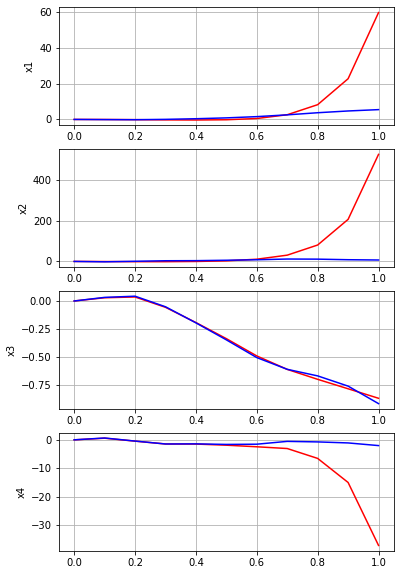

In [655]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_koop = x_koop_array[i,:]
    x_true = x_traj_true_array[i,:]
    plt.plot(tgrid, x_koop, 'r')
    plt.plot(tgrid, x_true, 'b')
    plt.ylabel('x' + str(i + 1))

K-MPC: bilinear motor

$$
\begin{aligned}
\dot{x}_{1} &=-\left(R_{a} / L_{a}\right) x_{1}-\left(k_{m} / L_{a}\right) x_{2} u+u_{a} / L_{a} \\
\dot{x}_{2} &=-(B / J) x_{2}+\left(k_{m} / J\right) x_{1} u-\tau_{l} / J \\
y &=x_{2}
\end{aligned}
$$

In [ ]:
def bilinear_motor_ode(x, u):

    La = 0.314
    Ra = 12.345
    km = 0.253
    J = 0.00441
    B = 0.00732
    tau_l = 1.47
    ua = 60
    
    x1p = - (Ra / La) * x[0] - (km / La) * x[1] * u[0] + ua / La
    x2p = - ( B / J) * x[1] + (km / J) * x[0] * u[0] - tau_l / J

    rhs = [x1p,
           x2p
           ]
    
    return ca.vertcat(*rhs)

In [ ]:
Nx = 2
Nu = 1

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)

ode = ca.Function("ode_func", [x_SX, u_SX], [bilinear_motor_ode(x_SX, u_SX)])
delta_t = 0.01


In [ ]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

In [ ]:
N_sim = 1000
N_traj = 200


In [ ]:
Cy_np = np.array([[0, 1]])
N_delay = 1
Ny = np.shape(Cy_np)[0]

U_data_np = 2*np.random.rand(N_sim, N_traj) - 1
X_init_data_np = np.random.rand(Nx,N_traj)*2 - 1

In [ ]:
X_list = []
Y_list = []
U_list = []

X_current_np = X_init_data_np

zeta_current = np.vstack([Cy_np @ X_current_np, np.zeros([N_delay * (Ny + Nu), N_traj])])

N_zeta = (N_delay+1)*Ny + N_delay * Nu

for i in range(N_sim):
    X_next_list = [sys_int_fn(X_current_np[:,j],U_data_np[i,j]) for j in range(N_traj)]
    X_next_np = np.hstack(X_next_list)
    
    zeta_prev = zeta_current
    zeta_current = np.vstack([Cy_np @ X_next_np, U_data_np[i,:], zeta_current[0:-Ny-Nu,:]])
    if(i > N_delay):

        X_list += [zeta_prev] 
        Y_list += [zeta_current]
        U_list += [U_data_np[i,:]]
    
    X_current_np = X_next_np  

In [ ]:
X_np = np.hstack(X_list)
Y_np = np.hstack(Y_list)
U_np = np.hstack(U_list).reshape(1,-1)

In [ ]:
N_rbf = 100
Xc = np.random.rand(N_zeta,N_rbf)*2 - 1

N_lift = N_rbf + N_zeta

In [ ]:
X_lift_np = lift_func(X_np, Xc)
Y_lift_np = lift_func(Y_np, Xc)

In [ ]:
W_np = np.vstack([Y_lift_np, X_np])
V_np = np.vstack([X_lift_np, U_np])
VVt_np = V_np @ V_np.T
WVt_np = W_np @ V_np.T
M_np = WVt_np @ np.linalg.pinv(VVt_np)
A_lift_np = M_np[0:N_lift,0:N_lift]
B_lift_np = M_np[0:N_lift,N_lift:]
C_lift_np = M_np[N_lift:,0:N_lift]

print('Regression residual %f \n' %  (np.linalg.norm(Y_lift_np - A_lift_np @ X_lift_np - B_lift_np @ U_np,'fro') / np.linalg.norm(Y_lift_np,'fro')) )

In [ ]:
N_sim = 300

ymin = -0.4
ymax = 0.4
x0 = np.array([[-0.1],[0.1]])

yrr = [0.5*np.cos(2*np.pi*(i +1) / N_sim) for i in range(N_sim)]

In [ ]:
C_np = np.zeros([N_lift,1])
C_np[0,0] = 1

In [ ]:
Q = np.diag([1])
R = np.diag([0.01])

In [ ]:
N_pred = 100

x_lift_min_list = [ymin] + [-ca.inf] * (N_lift - 1)
x_lift_max_list = [ymax] + [ca.inf] * (N_lift - 1)

ulb = [-1]
uub = [1]

In [ ]:
MPC_define(A_lift_np, B_lift_np, C_np, 0, Q, R, Q, N_pred, ulb, uub, x_lift_min_list, x_lift_max_list)

In [ ]:
def MPC_create_matrices(A_lift, B_lift, N_pred):
    include_x0 = 0
    
    Nx = np.shape(A_lift)[0]
    Ab = np.zeros([(N_pred + 1) * Nx, Nx])
    Ab[0:Nx,:] = np.eye(Nx)
    for i in range(2,N+2):
        if(np.shape(A_lift)[0] > 1000):
            pass
        Ab[(i-1)*Nx : i * n, :] = Ab[(i-2) * Nx: (i-1) * n, :] @ A_lift
    if(include_x0 == 0):
        Ab = Ab[Nx:,:]
        
    Nu = np.shape(B_lift)[1]
    Bb = np.zeros([(N_pred+1)*Nx, N_pred * Nu])
    for i in range(2,N_pred+2):
        Bb[(i-1)*Nx:i*Nx,:] = A @ Bb[(i-2)* Nx:(i-1):Nx,:]
        Bb[(i-1)*Nx:i*Nx,(i-2)*Nu:Nu*(i-1)] = B
        if(include_x0 == 0):
            Bb = Bb[Nx:,:]
    
    return Ab, Bb
    

In [ ]:
def MPC_define(A_lift, B_lift, C, d, Q ,R, Q_f , N_pred, ulb, uub, xlb, xub, solver = None, ulin = None, qlin = None):
    Nx = np.shape(A_lift)[0]
    Nu = np.shape(B_lift)[1]

    Ny = np.shape(C)[0]
    
    x0 = np.zeros([Nx,1])
    
    ulb = ulb * N_pred
    uub = uub * N_pred
    
    xlb = xlb * N_pred
    xub = xub * N_pred
    
    u_lin = np.zeros([Nu * N_pred, 1])
    q_lin = np.zeros([Ny * N_pred, 1])
    
    
    Ab_lift, Bb_lift = MPC_create_matrices(A_lift, B_lift, N_pred)
    
    Qb = np.zeros([Ny * N_pred, Ny * N_pred])
    Qb[0: Ny(N_pred-1), 0: Ny(N_pred-1)] = block_diag(*[Q]*(N_pred - 1 ))
    Qb[-p:,-p:] = Q_f
    
    Cb =  block_diag(*[C]*(N_pred))
    Rb =  block_diag(*[R]*(N_pred))
    
    

In [ ]:
test = np.array([[1,0],[0,1]])

block_diag(*[test]*2)


In [ ]:
np.diag([1])

SINDy

In [34]:
import pysindy as ps
from scipy.integrate import odeint

In [35]:
# Generate training data

def f(x, t):
    return [
        -0.1 * x[0] + 2 * x[1],
        -2 * x[0] - 0.1 * x[1]
    ]


dt = 0.01
t_train = np.arange(0, 25, dt)
x0_train = [2, 0]
x_train = odeint(f, x0_train, t_train)

In [36]:
poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

x0' = -0.100 x0 + 2.000 x1
x1' = -2.000 x0 + -0.100 x1


<ipython-input-37-7697132d31bf>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


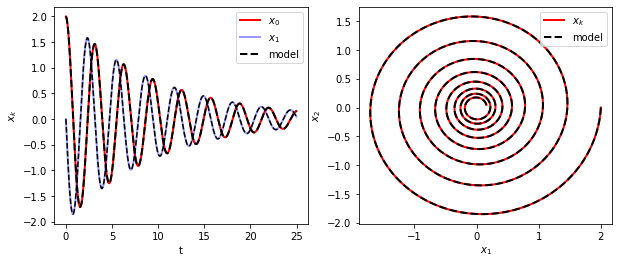

In [37]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

In [38]:
# Generate training data

def lorenz(x, t):
    return [
        10 * (x[1] - x[0]),
        x[0] * (28 - x[2]) - x[1],
        x[0] * x[1] - 8 / 3 * x[2],
    ]


dt = 0.001
t_train = np.arange(0, 100, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_dot_train_measured = np.array(
    [lorenz(x_train[i], 0) for i in range(t_train.size)]
)

# Fit the models and simulate

poly_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)  # Seed for reproducibility

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models = []
t_sim = np.arange(0, 20, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

<ipython-input-39-274d44834bd1>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


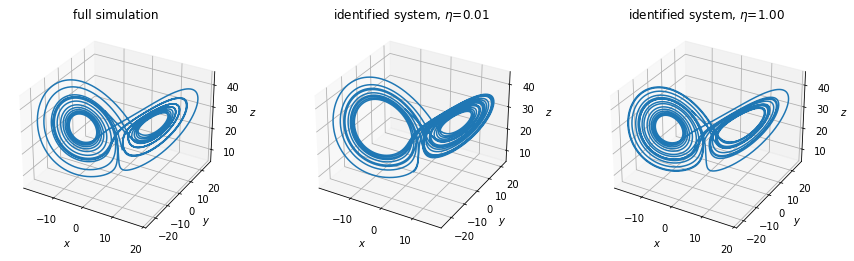

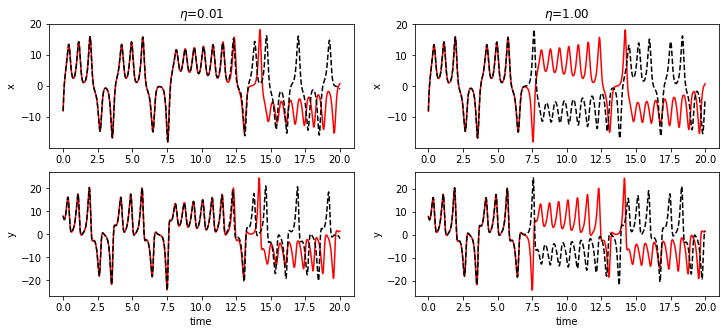

In [39]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()

https://pysindy.readthedocs.io/en/latest/examples/1_feature_overview.html#sindy-with-control-sindyc

In [40]:
# Control input
def u_fun(t):
    return np.column_stack([np.sin(2 * t), t ** 2])

# Lorenz equations with control input
def lorenz_control(z, t):
    u = u_fun(t)
    return [
        10 * (z[1] - z[0]) + u[0, 0] ** 2,
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - 8 / 3 * z[2] - u[0, 1],
    ]

In [41]:
# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz_control, x0_train, t_train)
u_train = u_fun(t_train)

In [42]:
model = ps.SINDy()
model.fit(x_train, u=u_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1 + 1.000 u0^2
x1' = 27.987 x0 + -0.997 x1 + -1.000 x0 x2
x2' = -2.666 x2 + -1.000 u1 + 1.000 x0 x1


In [43]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz_control, x0_test, t_test)
u_test = u_fun(t_test)

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, u=u_test, t=dt))

Model score: 1.000000


<ipython-input-44-bf3ecdf3d4e3>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


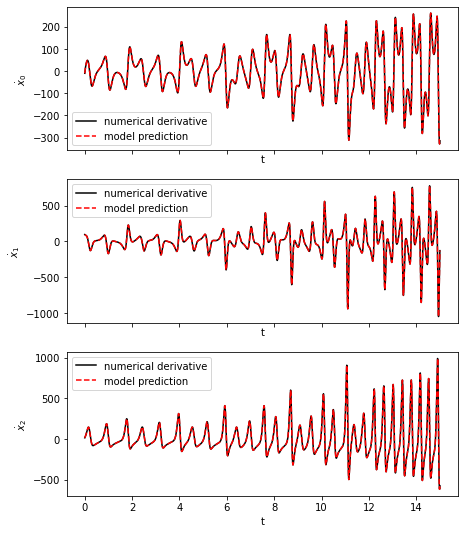

In [44]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test, u=u_test)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

<ipython-input-45-17ba5432f20a>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


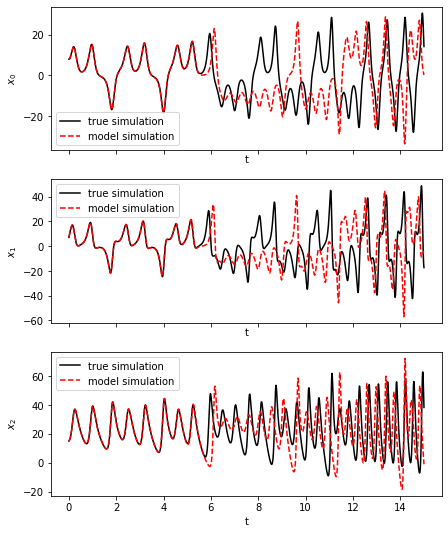

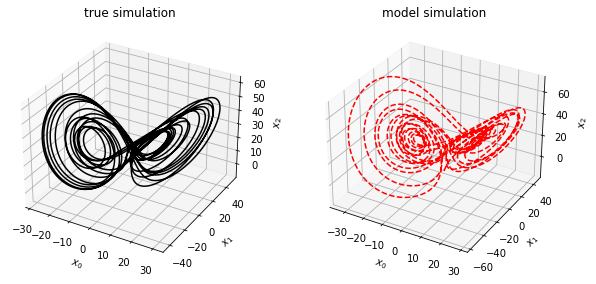

In [45]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test, u=u_fun)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

In [83]:
# Control input
def u_fun(t):
    return np.column_stack([np.sin(2 * t)])

# Lorenz equations with control input
def van_del_pol_control(z, t):
    u = u_fun(t)
    return [
        2. * z[1],
        -0.8 * z[0] + 2 * z[1] - 10 * z[0]**2 * z[1] + u[0,0],
    ]

In [84]:
dt = .001

t_train = np.arange(0, 10, dt)
x0_train = [1,1]
x_train = odeint(van_del_pol_control, x0_train, t_train)
u_train = u_fun(t_train)

In [85]:
# Instantiate and fit the SINDYc model
combined_library = ps.FourierLibrary(n_frequencies=3) +ps.PolynomialLibrary(degree=3)
model = ps.SINDy(feature_library=combined_library)
model.fit(x_train, u=u_train, t=dt)
model.print()

x0' = -0.011 sin(1 x1) + 2.010 x1 + -0.001 x1^3
x1' = 0.194 sin(1 x1) + -0.007 sin(2 x1) + -0.800 x0 + 1.820 x1 + 1.000 u0 + -10.000 x0^2 x1 + 0.023 x1^3


In [89]:
def u_fun(t):
    return np.column_stack([np.cos(2 * t)])


# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 50, dt)
x0_test = np.array([1,1])
x_test = odeint(van_del_pol_control, x0_test, t_test)
u_test = u_fun(t_test)

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, u=u_test, t=dt))

Model score: 1.000000


<ipython-input-90-bf3ecdf3d4e3>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


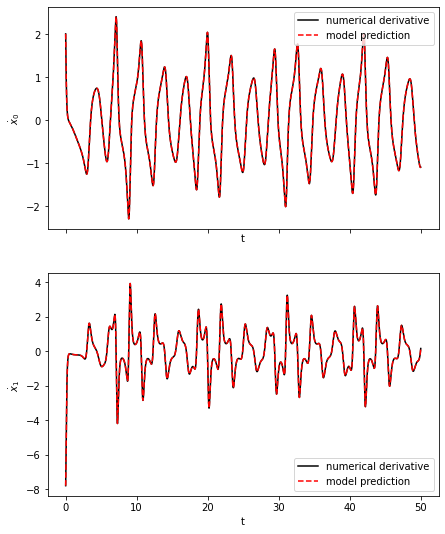

In [90]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test, u=u_test)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

<ipython-input-91-0f935feb5d0a>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


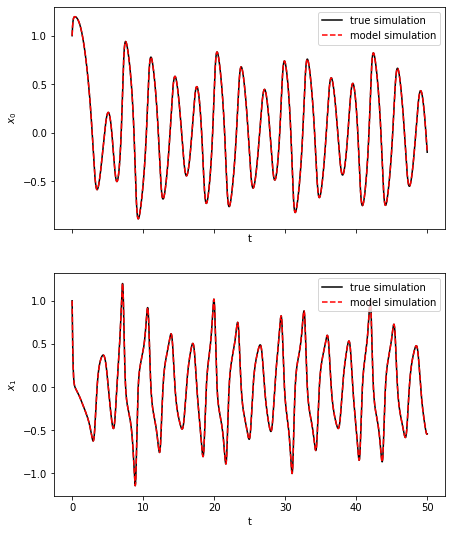

In [91]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test, u=u_fun)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig.show()

Inverted Pendulum

In [106]:
# Control input
def u_fun(t):
    return np.column_stack([np.sin(2 * t)])

# Lorenz equations with control input
def IP_control(z, t):
    u = u_fun(t)
    M  = 2.4
    m = 0.23
    l = 0.36
    g = 9.81
    return [
        z[1],
        ( u[0,0] * np.cos(z[0]) - (M+m) * g * np.sin(z[0]) + m * l * np.cos(z[0]) *np.sin(z[0])*z[1]**2) / (m*l*np.cos(z[0])**2 - (M+m) *l),
        z[3],
        (u[0,0] + m*l * np.sin(z[0]) * z[1]**2 - m*g*np.cos(z[0])*np.sin(z[0]))/(M+m-m*np.cos(z[0])**2),
    ]

In [123]:
dt = .1

t_train = np.arange(0, 20, dt)
x0_train = [0,0,0,0]
x_train = odeint(IP_control, x0_train, t_train)
u_train = u_fun(t_train)

In [124]:
# Instantiate and fit the SINDYc model
# model = ps.SINDy()
# combined_library = ps.FourierLibrary(n_frequencies=4) + ps.IdentityLibrary()
combined_library = ps.FourierLibrary(n_frequencies=3) +ps.PolynomialLibrary(degree=3)
model = ps.SINDy(feature_library=combined_library)
model.fit(x_train, u=u_train, t=dt)
model.print()

x0' = 0.984 x1
x1' = 26.039 sin(1 x0) + 2.030 sin(1 x2) + 0.470 sin(2 x0) + -0.488 sin(2 x2) + -1.122 cos(2 u0) + 0.581 sin(3 x0) + 0.135 cos(3 x2) + -0.236 sin(3 u0) + 0.611 1 + -0.176 x0 + -1.212 x2 + 0.209 x2 x3 + -1.733 u0^2 + 0.086 x1 x3 u0 + -0.465 x2 x3^2 + -1.396 x2 x3 u0 + 4.707 x3^2 u0 + -0.208 x3 u0^2 + -0.269 u0^3
x2' = 35.122 sin(1 x3) + -4.574 sin(2 x3) + -25.013 x3
x3' = 1.426 sin(1 x0) + -0.834 sin(2 x0) + -0.222 sin(3 x0) + 0.361 u0


In [125]:
def u_fun(t):
    return np.column_stack([np.sin(2 * t)])


# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 20, dt)
x0_test = np.array([0,0,0,0])
x_test = odeint(IP_control, x0_test, t_test)
u_test = u_fun(t_test)

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, u=u_test, t=dt))

Model score: 0.995189


<ipython-input-126-bf3ecdf3d4e3>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


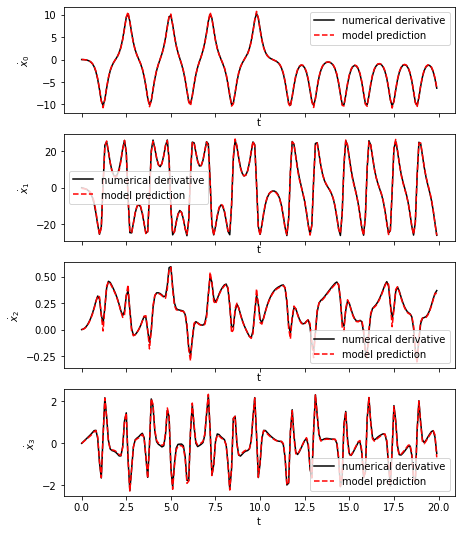

In [126]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test, u=u_test)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

<ipython-input-127-74f99b4d546e>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


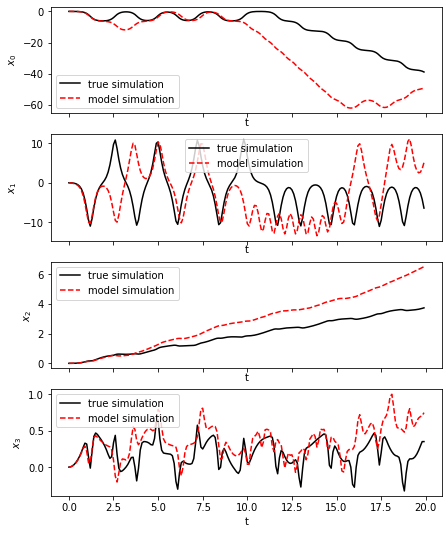

In [127]:
    # Evolve the new initial condition in time with the SINDy model
    x_test_sim = model.simulate(x0_test, t_test, u=u_fun)

    fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
    for i in range(x_test.shape[1]):
        axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
        axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
        axs[i].legend()
        axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))


    fig.show()